<a href="https://colab.research.google.com/github/khodozzz/portfolio/blob/main/1_NBA_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

from sklearn.ensemble import GradientBoostingRegressor

# Data Wrangling

Loading NBA player statistics

In [2]:
stats = pd.read_csv('nba_players_22_23.csv')
stats

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,1,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,...,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2,achiupr01
1,2,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,...,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6,adamsst01
2,3,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,...,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4,adebaba01
3,4,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,...,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,agbajoc01
4,5,Santi Aldama,PF,22,MEM,77,20,21.8,3.2,6.8,...,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0,aldamsa01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,535,Thaddeus Young,PF,34,TOR,54,9,14.7,2.0,3.7,...,1.3,1.8,3.1,1.4,1.0,0.1,0.8,1.6,4.4,youngth01
675,536,Trae Young,PG,24,ATL,73,73,34.8,8.2,19.0,...,0.8,2.2,3.0,10.2,1.1,0.1,4.1,1.4,26.2,youngtr01
676,537,Omer Yurtseven,C,24,MIA,9,0,9.2,1.8,3.0,...,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4,yurtsom01
677,538,Cody Zeller,C,30,MIA,15,2,14.5,2.5,3.9,...,1.7,2.6,4.3,0.7,0.2,0.3,0.9,2.2,6.5,zelleco01


In [4]:
def stats_wrangling(df):
    df_new = df.copy()

    # Removing rows with player statistics for multiple teams 
    # (keeping total season statistics)
    for p in df_new.Player:
        if len(df_new[df_new.Player == p]) > 1:
            df_new.drop(df_new[(df_new.Player == p) & (df_new.Tm != 'TOT')].index, inplace=True)
            #df_new.loc[df_new['Player'] == p, 'TeamChanged'] += 1

    # Setting the player name as the index
    df_new.set_index('Player', inplace=True)

    # Removing unnecessary columns
    df_new.drop(['Rk', 'Tm', 'Pos', 'Player-additional'], axis=True, inplace=True)

    # Dropping rows with missing values
    df_new = df_new.dropna()

    return df_new

Loading NBA player salaries

In [5]:
salary = pd.read_csv('nba_players_salary.csv')
salary

,Rk,Player,Tm,2022-23,2023-24,2024-25,2025-26,2026-27,2027-28,Guaranteed,Player-additional
0,1,Stephen Curry,GSW,$48070014,$51915615,$55761216,$59606817,NaN,NaN,$215353662,curryst01
1,2,Russell Westbrook,UTA,$47559433,NaN,NaN,NaN,NaN,NaN,$47063478,westbru01
2,3,LeBron James,LAL,$44474988,$53369986,$57639585,NaN,NaN,NaN,$97844974,jamesle01
3,4,Kevin Durant,PHO,$44119845,$47649433,$51179021,$54708609,NaN,NaN,$197656908,duranke01
4,5,Bradley Beal,WAS,$43279250,$46741590,$50203930,$53666270,$57128610,NaN,$193891040,bealbr01
...,...,...,...,...,...,...,...,...,...,...,...
561,562,Charles Bassey,PHI,$2674742,$2600000,$2500000,$2500000,NaN,NaN,$74742,bassech01
562,563,Trevor Keels,NYK,NaN,NaN,NaN,NaN,NaN,NaN,$58493,keelstr01
563,564,Lester Quinones,GSW,NaN,NaN,NaN,NaN,NaN,NaN,$58493,quinole01
564,565,Stanley Umude,DET,$58493,NaN,NaN,NaN,NaN,NaN,$58493,umudest01


In [6]:
def salary_wrangling(df):
    df_new = df.copy()

    # Selecting columns for player name and salary for the 2022-23 season
    df_new = df_new[['Player', '2022-23']]
    df_new = df_new.dropna()

    # Removing duplicate rows, keeping the last contract for players with multiple contracts
    df_new.drop_duplicates(subset='Player', keep='last',inplace=True)

    # Setting the player name as the index
    df_new.set_index('Player', inplace=True)

    # Renaming the salary column and converting values to integers
    df_new.rename(columns={'2022-23': 'Salary'}, inplace=True)
    df_new['Salary'] = df_new['Salary'].str.replace('$', '').astype(int)

    return df_new

Creating ready-to-use dataset 

In [7]:
data = stats_wrangling(stats).join(salary_wrangling(salary), how='inner')
data

<ipython-input-6-51fc0c62a636>:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_new['Salary'] = df_new['Salary'].str.replace('$', '').astype(int)


,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary
Player,,,,,,,,,,,,,,,,,,,,,
Precious Achiuwa,23,55,12,20.7,3.6,7.3,0.485,0.5,2.0,0.269,...,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2,2840160
Steven Adams,29,42,42,27.0,3.7,6.3,0.597,0.0,0.0,0.000,...,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6,17926829
Bam Adebayo,25,75,75,34.6,8.0,14.9,0.540,0.0,0.2,0.083,...,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4,30351780
Ochai Agbaji,22,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,...,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,3918360
Santi Aldama,22,77,20,21.8,3.2,6.8,0.470,1.2,3.5,0.353,...,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0,2094120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thaddeus Young,34,54,9,14.7,2.0,3.7,0.545,0.1,0.6,0.176,...,1.3,1.8,3.1,1.4,1.0,0.1,0.8,1.6,4.4,8000000
Trae Young,24,73,73,34.8,8.2,19.0,0.429,2.1,6.3,0.335,...,0.8,2.2,3.0,10.2,1.1,0.1,4.1,1.4,26.2,37096500
Omer Yurtseven,24,9,0,9.2,1.8,3.0,0.593,0.3,0.8,0.429,...,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4,1752638


# Exploratory Data Analysis 

Correlation heatmap

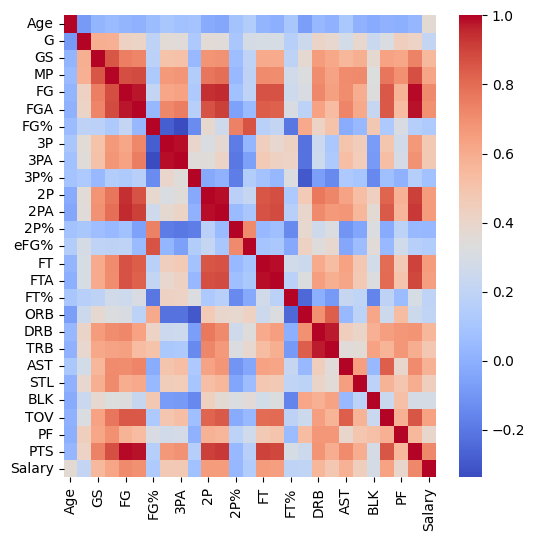

In [14]:
plt.figure(figsize=(6, 6))
sns.heatmap(data.corr(), cmap='coolwarm')
plt.show()

Filtering highly correlated columns

In [18]:
low_corr_cols = data.columns
low_corr = abs(data.corr()) < 0.75
for i in low_corr.columns:
    for j in low_corr.columns:
        if i != j and low_corr[i][j] == False and j in low_corr_cols:
            low_corr_cols = low_corr_cols.drop(j)

low_corr_cols

Index(['Age', 'G', '3P%', '2P%', 'FT%', 'STL', 'BLK', 'PF', 'Salary'], dtype='object')

Correlation heatmap with reduced columns

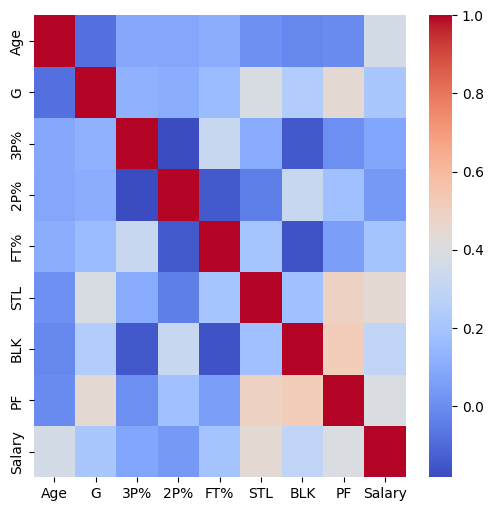

In [19]:
plt.figure(figsize=(6, 6))
sns.heatmap(data[low_corr_cols].corr(), cmap='coolwarm')
plt.show()

Pairwise plot

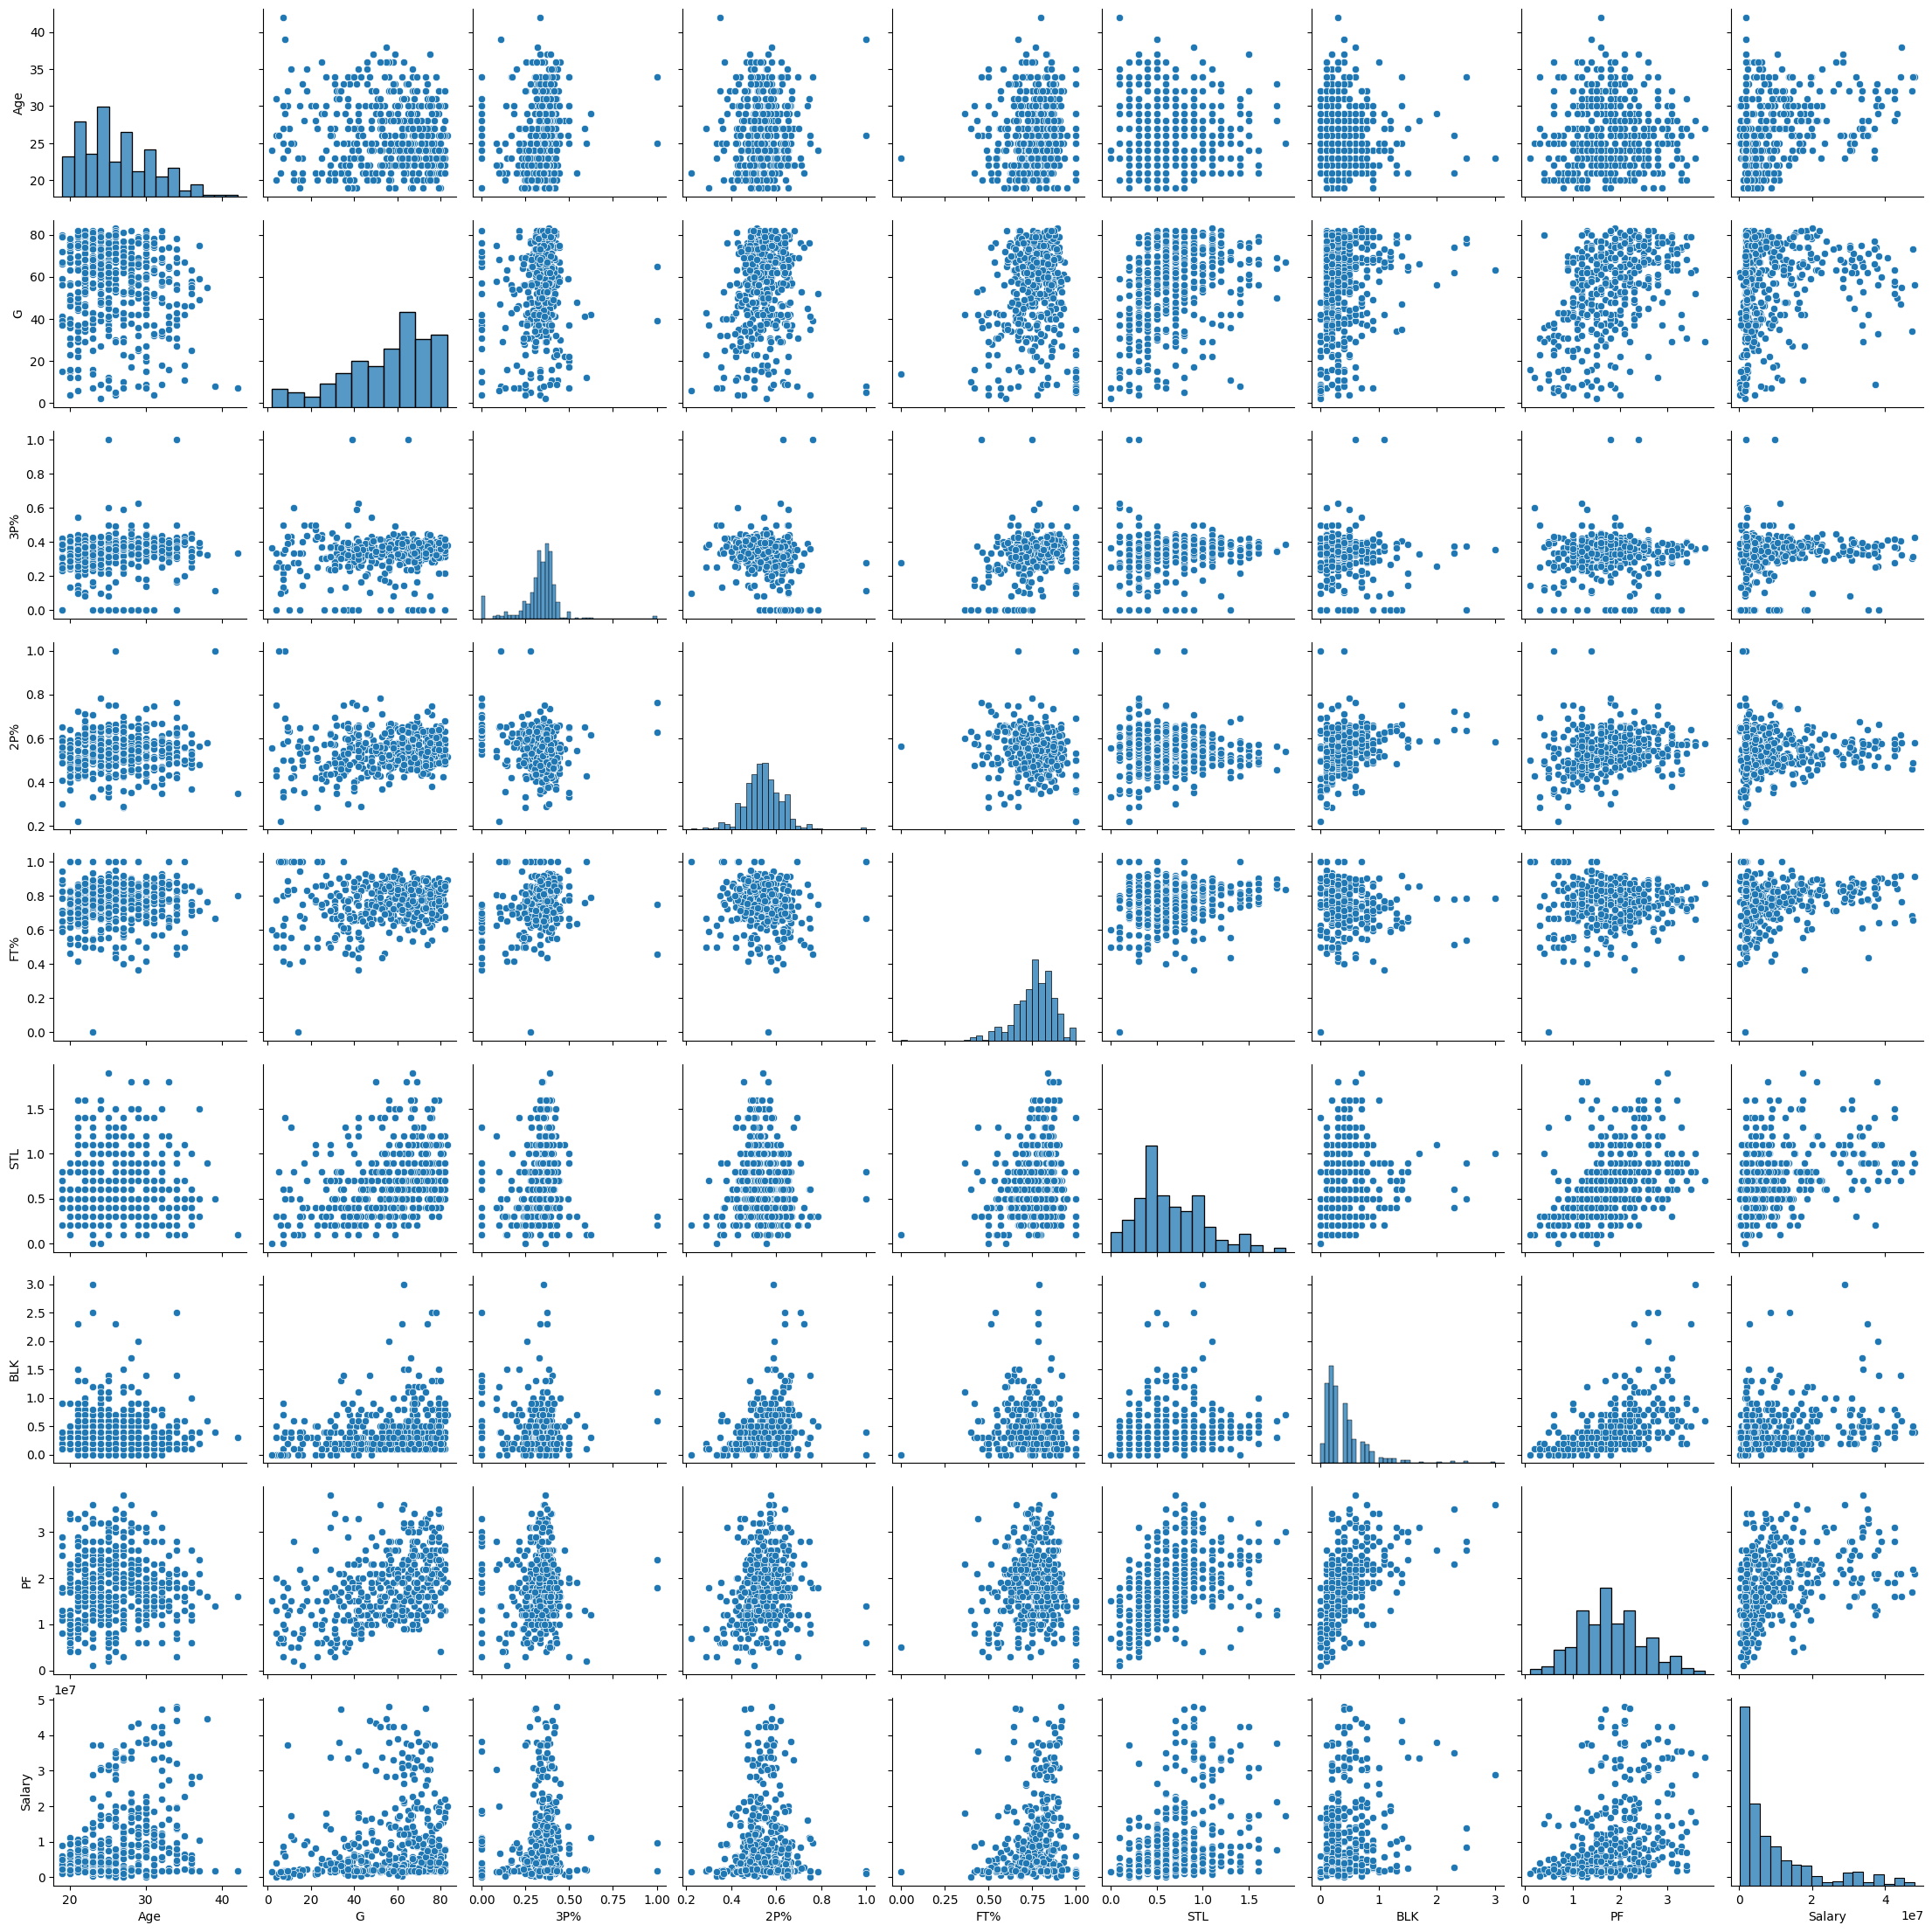

In [20]:
sns.pairplot(data=data, vars=low_corr_cols)
plt.show()

# Model Training and Evaluation

Splitting the data into training and testing sets


In [27]:
X = data.drop('Salary', axis=True)
y = data['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Feature Selection

In [29]:
regressor = GradientBoostingRegressor()

selector = RFECV(regressor, 
                 step=1, 
                 cv=5,
                 scoring='r2')
selector = selector.fit(X, y)
selector.support_

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True])

In [30]:
X_train_supported = X_train.to_numpy()[:, selector.support_]
X_test_supported = X_test.to_numpy()[:, selector.support_]

## Training 

In [31]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train_supported, y_train)

GradientBoostingRegressor()

## Evaluating

In [32]:
y_pred = regressor.predict(X_test_supported)

Evaluating the model performance using R-squared score


In [33]:
metrics.r2_score(y_test, y_pred)

0.8829370611761521

Comparing actual and predicted salaries

In [34]:
salary_comp = pd.DataFrame(y_test)  # salary_comp = pd.DataFrame(y)
salary_comp['Prediction'] = y_pred 

In [35]:
salary_comp.to_csv('test_salary.csv')

Visualizing salary comparison in bar charts

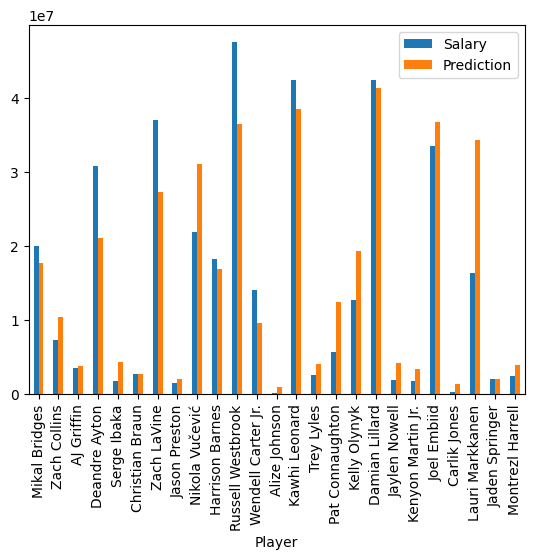

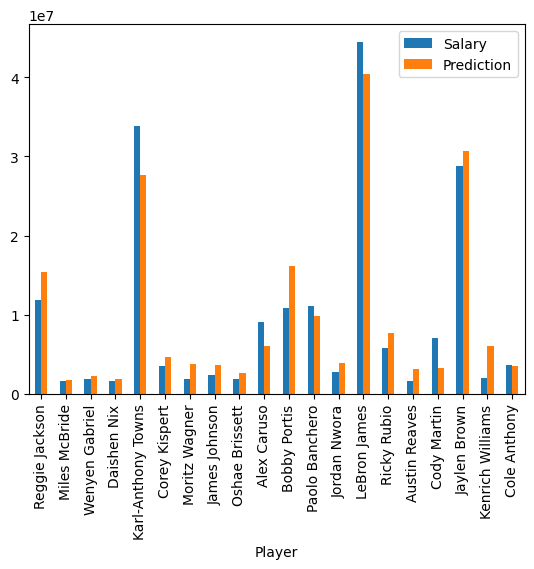

In [36]:
for i in range(0, len(salary_comp), 25):
    salary_comp[i:i + 25].plot.bar()
    plt.show()